# COVID-19 EDA and Hypothesis Testing

### Data is sourced from:

https://github.com/nytimes/covid-19-data

### Other sources:

https://covidtracking.com/data/state/california/
https://covidtracking.com/api
https://covid19.healthdata.org/projections

In [1]:
import math

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.stats as stats
import random

## Explore and clean the data

#### Load the data into a Pandas DataFrame

In [2]:
us_covid = pd.read_csv('../datasets/covid-19-data/us-states.csv')
us_covid_cases = us_covid[['date', 'state', 'cases']].copy()
dates = us_covid['date'].unique()
states = us_covid['state'].unique()

#### Use a pivot table to move the data into columns/rows.

In [3]:
us_covid_cases_table = us_covid_cases.pivot(index='state', columns='date', values='cases')
us_covid_cases_table.fillna(0, inplace=True)

#### Convert column names to date time objects.

In [4]:
us_covid_cases_table.columns = pd.to_datetime(us_covid_cases_table.columns)

#### Display table for number of cases

In [5]:
us_covid_cases_table

date,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,639.0,720.0,830.0,947.0,999.0,1106.0,1270.0,1535.0,1633.0,1841.0
Alaska,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85.0,102.0,114.0,119.0,133.0,143.0,146.0,156.0,169.0,185.0
Arizona,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,665.0,773.0,929.0,1169.0,1298.0,1413.0,1600.0,1769.0,2019.0,2269.0
Arkansas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,386.0,409.0,449.0,508.0,564.0,624.0,683.0,738.0,743.0,853.0
California,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,...,4914.0,5565.0,6266.0,7421.0,8582.0,9816.0,10995.0,12569.0,13796.0,15076.0
Colorado,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1735.0,2061.0,2315.0,2628.0,2990.0,3346.0,3728.0,4182.0,4574.0,4950.0
Connecticut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1291.0,1524.0,1993.0,2571.0,3128.0,3557.0,3824.0,4915.0,5276.0,5675.0
Delaware,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,165.0,214.0,232.0,264.0,319.0,368.0,393.0,450.0,593.0,673.0
District of Columbia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,304.0,342.0,342.0,495.0,495.0,586.0,653.0,757.0,902.0,998.0


#### Create empty array for the daily increases percent = (that days # - prev days #) / prev day

In [6]:
us_covid_increases = pd.DataFrame(index=us_covid_cases_table.index.values, 
                                  columns=us_covid_cases_table.columns.values)
us_covid_increases.fillna(0, inplace=True)


#### Fill empty array with the daily increases from the us_covid_cases_table data

In [12]:
for each_date in us_covid_increases.columns.values:
    if each_date == us_covid_increases.columns.values[0]:
        pass
    else:
        us_covid_increases[each_date] = ((us_covid_cases_table[each_date] -
                                         us_covid_cases_table[each_date - pd.Timedelta(days=1)]) / 
                                         us_covid_cases_table[each_date - pd.Timedelta(days=1)]) * 100
        
        

#### Display table for percent increases

In [13]:
us_covid_increases

,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05
Alabama,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.773234,12.676056,15.277778,14.096386,5.491024,10.710711,14.828210,20.866142,6.384365,12.737293
Alaska,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.188406,20.000000,11.764706,4.385965,11.764706,7.518797,2.097902,6.849315,8.333333,9.467456
Arizona,0,NaN,NaN,NaN,NaN,inf,0.0,0.0,0.0,0.0,...,30.905512,16.240602,20.181113,25.834230,11.035073,8.859784,13.234253,10.562500,14.132278,12.382368
Arkansas,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.971510,5.958549,9.779951,13.140312,11.023622,10.638298,9.455128,8.052709,0.677507,14.804845
California,0,NaN,NaN,NaN,inf,100.0,0.0,0.0,0.0,0.0,...,21.034483,13.247863,12.596586,18.432812,15.644792,14.378933,12.011002,14.315598,9.762113,9.278052
Colorado,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,21.159218,18.789625,12.324115,13.520518,13.774734,11.906355,11.416617,12.178112,9.373505,8.220376
Connecticut,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.569170,18.048025,30.774278,29.001505,21.664722,13.714834,7.506326,28.530335,7.344863,7.562547
Delaware,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.384615,29.696970,8.411215,13.793103,20.833333,15.360502,6.793478,14.503817,31.777778,13.490725
District of Columbia,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.857678,12.500000,0.000000,44.736842,0.000000,18.383838,11.433447,15.926493,19.154557,10.643016
Florida,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.107792,26.266417,22.387320,15.216512,18.387777,15.190625,15.904701,14.000000,12.446394,6.977550


#### Change 'NaN' and 'inf' values to 0 

NaN occurs when there were no record cases on that day and the day before (e.g., 0/0)

Inf occurs when there was a case reported on that day but none on the day before (e.g., 1/0)

In [17]:
us_covid_increases.fillna(0, inplace=True)
us_covid_increases.replace(np.inf, 0, inplace=True)

In [18]:
us_covid_increases

,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,...,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05
Alabama,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.773234,12.676056,15.277778,14.096386,5.491024,10.710711,14.828210,20.866142,6.384365,12.737293
Alaska,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.188406,20.000000,11.764706,4.385965,11.764706,7.518797,2.097902,6.849315,8.333333,9.467456
Arizona,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,30.905512,16.240602,20.181113,25.834230,11.035073,8.859784,13.234253,10.562500,14.132278,12.382368
Arkansas,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.971510,5.958549,9.779951,13.140312,11.023622,10.638298,9.455128,8.052709,0.677507,14.804845
California,0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,...,21.034483,13.247863,12.596586,18.432812,15.644792,14.378933,12.011002,14.315598,9.762113,9.278052
Colorado,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.159218,18.789625,12.324115,13.520518,13.774734,11.906355,11.416617,12.178112,9.373505,8.220376
Connecticut,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.569170,18.048025,30.774278,29.001505,21.664722,13.714834,7.506326,28.530335,7.344863,7.562547
Delaware,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.384615,29.696970,8.411215,13.793103,20.833333,15.360502,6.793478,14.503817,31.777778,13.490725
District of Columbia,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.857678,12.500000,0.000000,44.736842,0.000000,18.383838,11.433447,15.926493,19.154557,10.643016
Florida,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,29.107792,26.266417,22.387320,15.216512,18.387777,15.190625,15.904701,14.000000,12.446394,6.977550


## Plot the Percent Increases Over Time

In [25]:
def plot_percent_changes(ax, data, dates, label):
    '''Plots the dates/data on the given axis and applies a label to it.'''
    data_ = data[data>0] #get only the data that is more than 0
    dates_ = dates[data>0] #get only the dates that the data is more than 0
    ax.plot(dates_, data_, label = label)

In [38]:
def generate_labels(ax):
    ax.legend(fontsize=20)
    fig.autofmt_xdate()
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 4));
    ax.set_ylabel('Percent Change Per Day')
    ax.yaxis.label.set_size(20)
    ax.set_xlabel('Date')
    ax.xaxis.label.set_size(20)

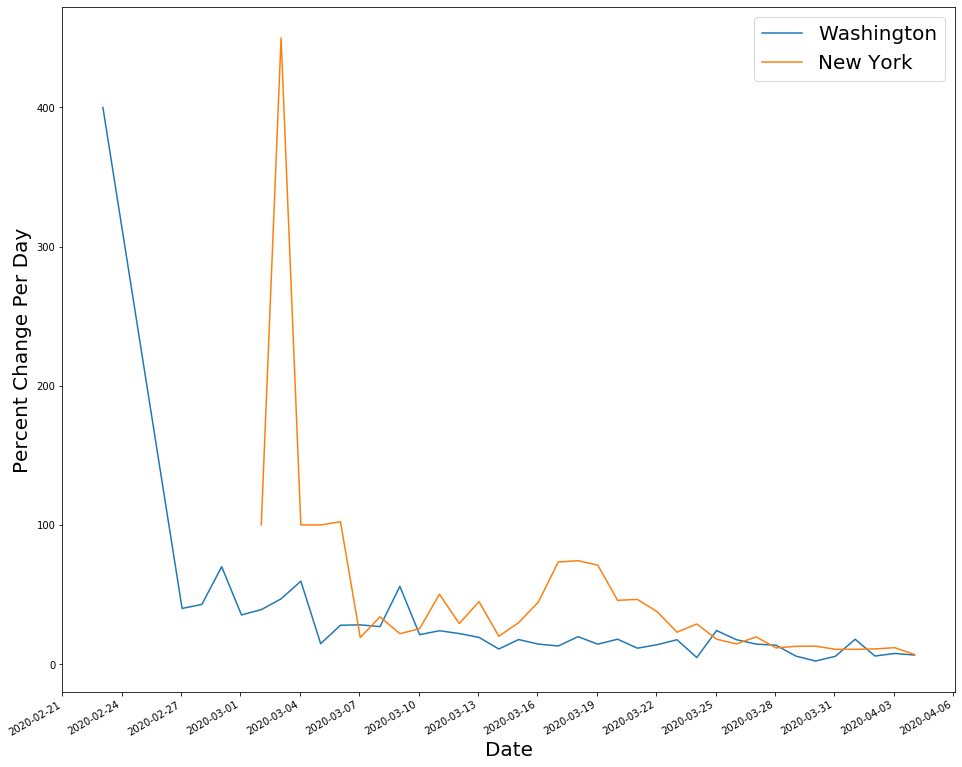

In [30]:
fig, ax = plt.subplots(figsize=(16,14))
plot_percent_changes(ax, us_covid_increases.loc['Washington', :], 
                     us_covid_cases_table.columns.values, 'Washington')
plot_percent_changes(ax, us_covid_increases.loc['New York', :], 
                     us_covid_cases_table.columns.values, 'New York')
generate_labels(ax)

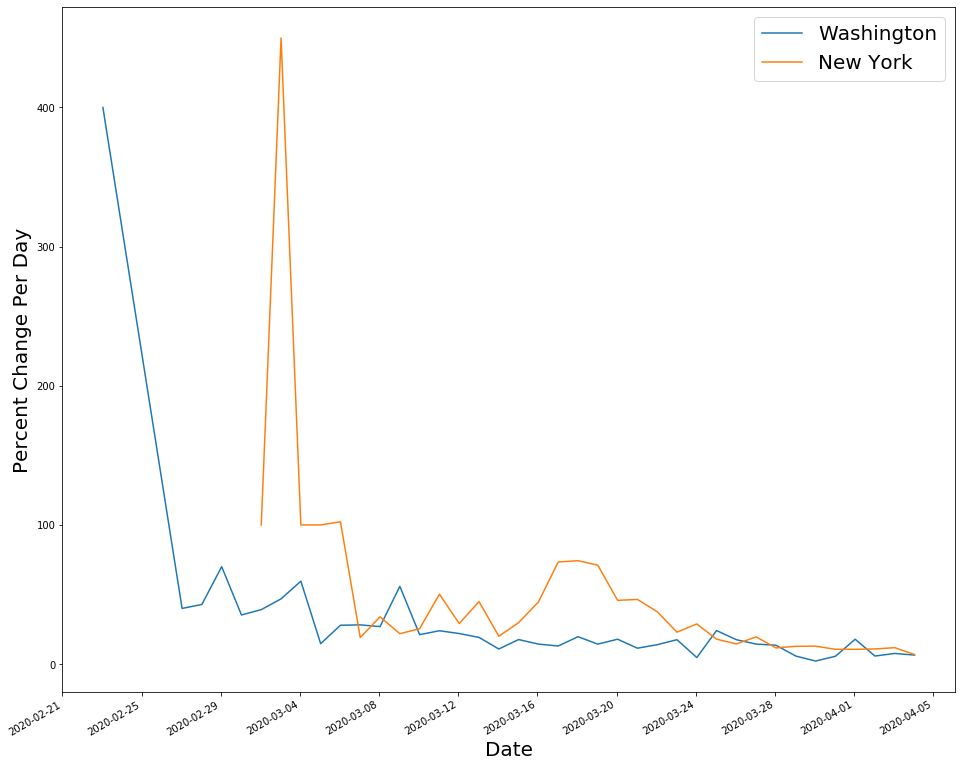

In [39]:
fig, ax = plt.subplots(figsize=(16,14))
plot_percent_changes(ax, us_covid_increases.loc['Washington', :], 
                     us_covid_cases_table.columns.values, 'Washington')
plot_percent_changes(ax, us_covid_increases.loc['New York', :], 
                     us_covid_cases_table.columns.values, 'New York')
generate_labels(ax)